# Beyond Accuracy: Understanding and Quantifying Uncertainty in Deep Learning Models

ELLIS Summer School: AI for Earth and Climate Sciences, Jena (Germany), September 1–5, 2025

Prepared By: Aishwarya Venkataramanan

This demo introduces methods to calibrate a deep learning classifier network on MNIST dataset.

In [1]:
# Import libraries
import torch
from PIL import Image
from torch import nn,save,load
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim import LBFGS
import torch.nn.functional as F
from sklearn.calibration import calibration_curve
import numpy as np
from torchvision.transforms.functional import to_pil_image

torch.manual_seed(5)

Load the MNIST dataset. The data is automatically downloaded in the "data" folder. We then split the test dataset into a validation and test set. The validation set is used to tune hyperparameters, and the test set is used for the final evaluation. 

In [2]:
# Loading Data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="data", download=True, train=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)
val_size = 5000
test_size = len(test_dataset) - val_size
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# 3. Create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Define a simple 3 layer CNN as a feature extractor. The network finally converts the features into logits for every class.

In [3]:
# Define the image classifier model
class ImageClassifier(nn.Module):
    def __init__(self, dropout_rate=0.50):
        super(ImageClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.Dropout(dropout_rate),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 22 * 22, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [4]:
# Create an instance of the image classifier model
device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = ImageClassifier().to(device)

We use the Adam optimizer and a cross entropy loss for training the model.

In [5]:
# Define the optimizer and loss function
optimizer = Adam(classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

Next, train the model and save the model parameters

In [6]:
# Train the model
for epoch in range(10):  # Train for 10 epochs
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Reset gradients
        outputs = classifier(images)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    print(f"Epoch:{epoch} loss is {loss.item()}")

Epoch:0 loss is 0.03558102250099182
Epoch:1 loss is 0.29298582673072815
Epoch:2 loss is 0.03923908621072769
Epoch:3 loss is 0.0074578565545380116
Epoch:4 loss is 0.2821025252342224
Epoch:5 loss is 0.0023232970852404833
Epoch:6 loss is 0.005093085579574108
Epoch:7 loss is 0.0015409787883982062
Epoch:8 loss is 0.008162971585988998
Epoch:9 loss is 0.0031861502211540937


In [7]:
# Save the trained model
torch.save(classifier.state_dict(), 'ckpt/model_state.pt')

In [8]:
# Load the saved model
with open('ckpt/model_state.pt', 'rb') as f: 
     classifier.load_state_dict(load(f))  

Now that the model has been trained, let's see how it performs on a sample image from the MNIST test dataset. 

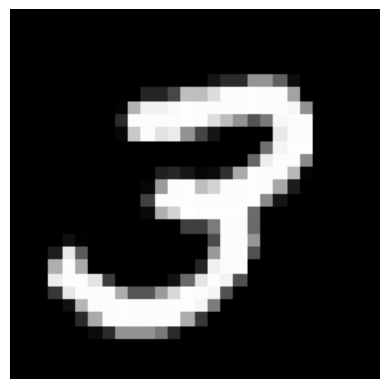

Predicted label: 3
Confidence: 0.9999926090240479


In [9]:
# Perform inference on an image
img = Image.open('data/three.png').convert('L')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
img_transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor()])
img_tensor = img_transform(img).unsqueeze(0).to(device)
output = classifier(img_tensor)
probs = torch.softmax(output, dim=1)
predicted_label = torch.argmax(probs, dim=1).item()
print(f"Predicted label: {predicted_label}")
print(f"Confidence: {torch.max(probs).item()}")

Notice that the model has predicted correctly with almost 100% "confidence". This seems positive since the model predicts correctly and is also confident about the prediction. 

Next, lets test the model on an image type that it has never seen before during the training. This type of data is also known as the Out-of-Distribution (OOD) dataset. The below example is an image extracted from the Fashion MNIST dataset. 

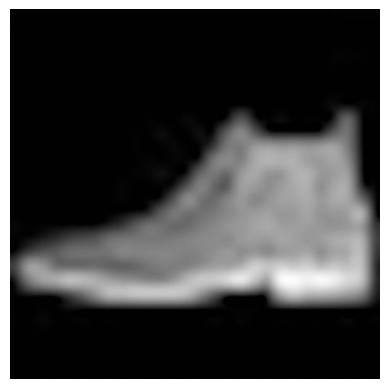

Predicted label: 2
Confidence: 0.9261510968208313


In [10]:
# Perform inference on an image
img = Image.open('data/shoe.png').convert('L')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
img_transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor()])
img_tensor = img_transform(img).unsqueeze(0).to(device)
output = classifier(img_tensor)
probs = torch.softmax(output, dim=1)
predicted_label = torch.argmax(probs, dim=1).item()
print(f"Predicted label: {predicted_label}")
print(f"Confidence: {torch.max(probs).item()}")

Notice how the model has predicted the incorrect label with a very high confidence (approx 93%)! Ideally, the network should have made a prediction with a very low confidence, but here, it seems to be "overconfident" in its prediction. 
This is a common problem observed in most of the modern deep learning models. As the complexity of the model increases, the models tend to produce overconfident predictions. 

Now lets plot the calibration graph for the model, also known as the reliability diagram. It's a visual tool to qualitatively assess model calibration by binning predictions by confidence level. For a perfect calibration, the confidence and accuracy of the samples should match

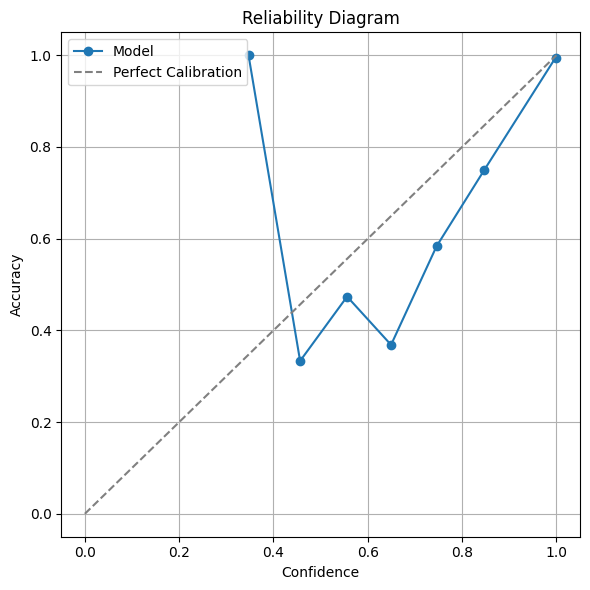

In [11]:
classifier.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = classifier(x)
        probs = torch.softmax(logits, dim=1)
        confs, preds = torch.max(probs, dim=1)

        all_probs.extend(confs.cpu().numpy())
        all_labels.extend((preds == y.to(device)).cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Compute calibration curve (reliability diagram)
prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)

# Plot reliability diagram
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Simple methods to calibrate deep learning classifiers.

Below, we will see four of the well-known methods used to calibrate predictions from deep learning models:
1. Temperature Scaling
2. MC Dropout
3. Deep Ensembles
4. Test Time Augmentation


# Temperature Scaling

![Image explaining temperature scaling](images/temp_scaling.png "Title")

We use the validation set to tune the temperature parameter. The logits produced by the model are divided by a scalar temperature $T > 0$, which is optimized to minimize the negative log-likelihood (NLL) on the validation set. A higher temperature smooths the predicted probabilities, reducing overconfidence, while a lower temperature sharpens them.

In [12]:
class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)

    def forward(self, input):
        logits = self.model(input)
        return logits / self.temperature

def temperature_scale(model, val_loader, device):
    model.eval()
    temp_model = ModelWithTemperature(model).to(device)

    # Collect all logits and labels from the validation set
    logits_list, labels_list = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            logits_list.append(logits)
            labels_list.append(labels)

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    # Define optimizer and loss
    optimizer = LBFGS([temp_model.temperature], lr=0.1, max_iter=100)
    loss_fn = nn.CrossEntropyLoss()

    def eval():
        optimizer.zero_grad()
        loss = loss_fn(logits / temp_model.temperature, labels)
        loss.backward()
        return loss

    optimizer.step(eval)
    print(f"Optimal temperature: {temp_model.temperature.item():.4f}")
    return temp_model



In [13]:
calibrated_model = temperature_scale(classifier, val_loader, device)

Optimal temperature: 1.3845


Let's plot the reliability diagram for this model.

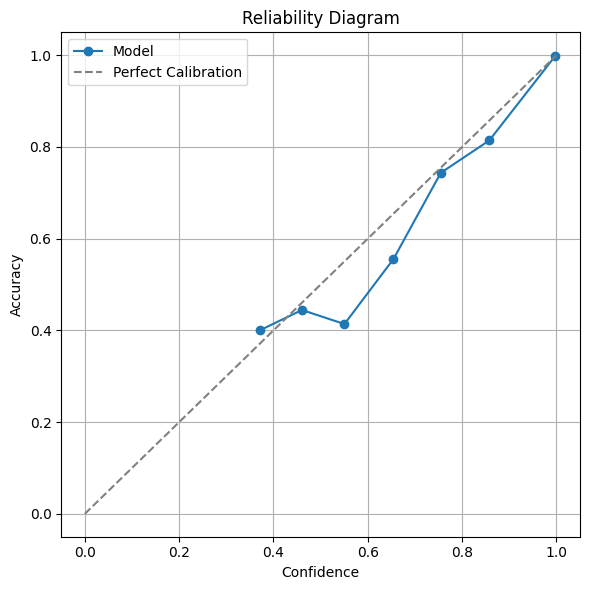

In [14]:
calibrated_model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = calibrated_model(x)
        probs = torch.softmax(logits, dim=1)
        confs, preds = torch.max(probs, dim=1)

        all_probs.extend(confs.cpu().numpy())
        all_labels.extend((preds == y.to(device)).cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Compute calibration curve (reliability diagram)
prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)

# Plot reliability diagram
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Notice how the model calibration has improved compared to the standard CNN model. Now let's see how the model performs on a sample in-distribution and OOD data.

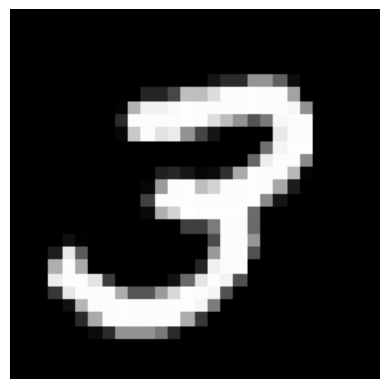

Predicted label: 3
Confidence: 0.9997045397758484


In [15]:
# Perform inference on an image
img = Image.open('data/three.png').convert('L')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
img_transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor()])
img_tensor = img_transform(img).unsqueeze(0).to(device)
output = calibrated_model(img_tensor)
probs = torch.softmax(output, dim=1)
predicted_label = torch.argmax(probs, dim=1).item()
print(f"Predicted label: {predicted_label}")
print(f"Confidence: {torch.max(probs).item()}")

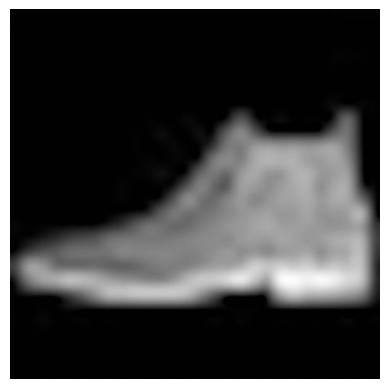

Predicted label: 2
Confidence: 0.5717692971229553


In [16]:
# Perform inference on an image
img = Image.open('data/shoe.png').convert('L')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
img_transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor()])
img_tensor = img_transform(img).unsqueeze(0).to(device)
output = calibrated_model(img_tensor)
probs = torch.softmax(output, dim=1)
predicted_label = torch.argmax(probs, dim=1).item()
print(f"Predicted label: {predicted_label}")
print(f"Confidence: {torch.max(probs).item()}")

# Monte Carlo Dropout

At test time, dropout is kept active and the model is run multiple times with different dropout masks. This produces a distribution of predictions rather than a single output. The mean of these predictions gives the final estimate.

![Image explaining MCD](images/mcd.png)

In [17]:
# MC Dropout
def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def mc_dropout_single_sample(model, input_tensor, n_iter=20):
    """
    Performs MC Dropout on a single input tensor.
    
    Args:
        model: PyTorch model with dropout layers
        input_tensor: 1 input sample of shape (1, C, H, W), already on the correct device
        n_iter: Number of stochastic forward passes

    Returns:
        Tensor of shape (n_iter, num_classes) with softmax probabilities
    """
    model.eval()
    enable_dropout(model)
    preds = []
    
    with torch.no_grad():
        for _ in range(n_iter):
            output = model(input_tensor)  # shape: (1, num_classes)
            probs = torch.softmax(output, dim=1)
            preds.append(probs.cpu().squeeze(0))  # shape: (num_classes,)
    
    return torch.stack(preds)  # shape: (n_iter, num_classes)


def mc_dropout_inference(model, data_loader, n_iter=30):
    """
    Perform MC Dropout inference on a dataset.

    Args:
        model: Trained model with dropout layers
        data_loader: DataLoader (test set)
        n_iter: Number of stochastic forward passes

    Returns:
        mean_probs: Tensor of shape (N, C) – mean predicted probabilities
        std_probs: Tensor of shape (N, C) – stddev of predicted probabilities
        predicted_labels: Tensor of predicted class indices (N,)
    """
    model.eval()
    enable_dropout(model)

    all_iter_probs = []

    with torch.no_grad():
        for _ in range(n_iter):
            probs = []
            for x, _ in data_loader:
                x = x.to(device)
                output = model(x)
                prob = torch.softmax(output, dim=1)
                probs.append(prob.cpu())
            all_iter_probs.append(torch.cat(probs, dim=0))  # shape (N, C)

    # Stack predictions: shape (n_iter, N, C)
    stacked = torch.stack(all_iter_probs)

    # Compute statistics over MC iterations
    mean_probs = stacked.mean(dim=0)  # shape (N, C)
    std_probs = stacked.std(dim=0)    # shape (N, C)
    predicted_labels = mean_probs.argmax(dim=1)

    return mean_probs, std_probs, predicted_labels



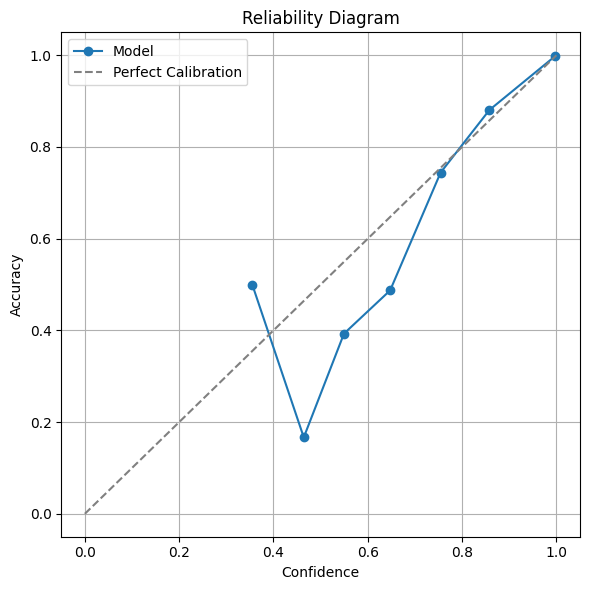

In [18]:
mean_probs, std_probs, preds = mc_dropout_inference(classifier, test_loader, n_iter=30)

# For confidence & uncertainty
confidences = mean_probs.max(dim=1).values          # (N,)
uncertainties = std_probs.mean(dim=1)               # (N,)

# Compute calibration curve (reliability diagram)
prob_true, prob_pred = calibration_curve(all_labels, confidences, n_bins=10)

# Plot reliability diagram
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

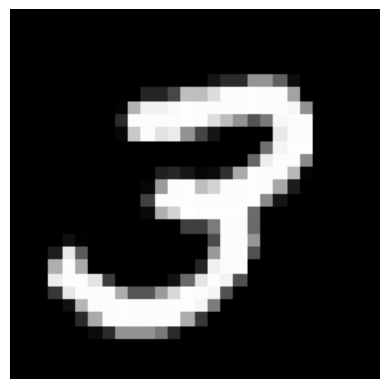

Predicted label: 3
Confidence (mean): 1.0000


In [19]:
# Perform inference on an image
img = Image.open('data/three.png').convert('L')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
img_transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor()])
img_tensor = img_transform(img).unsqueeze(0).to(device)
mc_outputs = mc_dropout_single_sample(classifier, img_tensor)
# Compute mean and std of predicted probabilities
mean_probs = mc_outputs.mean(dim=0)
std_probs = mc_outputs.std(dim=0)

# Get prediction and confidence
predicted_label = mean_probs.argmax().item()
confidence = mean_probs.max().item()

print(f"Predicted label: {predicted_label}")
print(f"Confidence (mean): {confidence:.4f}")

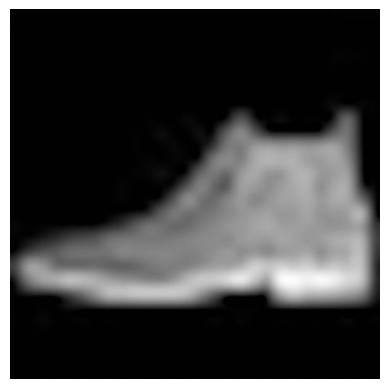

Predicted label: 2
Confidence (mean): 0.6019


In [20]:
# Perform inference on an image
img = Image.open('data/shoe.png').convert('L')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
img_transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor()])
img_tensor = img_transform(img).unsqueeze(0).to(device)
mc_outputs = mc_dropout_single_sample(classifier, img_tensor)
# Compute mean and std of predicted probabilities
mean_probs = mc_outputs.mean(dim=0)
std_probs = mc_outputs.std(dim=0)

# Get prediction and confidence
predicted_label = mean_probs.argmax().item()
confidence = mean_probs.max().item()

print(f"Predicted label: {predicted_label}")
print(f"Confidence (mean): {confidence:.4f}")

# Deep Ensemble

The idea is to train multiple neural networks with different random initializations (and sometimes data shuffling). Each model provides a prediction, and their outputs are aggregated by averaging the predictive distributions.

![image.png](images/ensemble.png)

In [21]:

# Deep Ensemble
def train_ensemble(n_models, train_loader, epochs=3):
    ensemble = []
    for i in range(n_models):
        model = ImageClassifier().to(device)
        optimizer = Adam(model.parameters(), lr=0.001)
        for epoch in range(epochs):
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = nn.CrossEntropyLoss()(model(x), y)
                loss.backward()
                optimizer.step()
        ensemble.append(model)
    return ensemble

def ensemble_predict_single_sample(ensemble, input_tensor):
    """
    Performs Deep Ensemble inference on a single input sample.
    
    Args:
        ensemble: list of trained models
        input_tensor: input of shape (1, C, H, W), already on device

    Returns:
        Tensor of shape (n_models, num_classes) with softmax probabilities
    """
    preds = []
    with torch.no_grad():
        for model in ensemble:
            model.eval()
            output = model(input_tensor)
            probs = torch.softmax(output, dim=1)
            preds.append(probs.cpu().squeeze(0))  # shape: (num_classes,)
    return torch.stack(preds)  # shape: (n_models, num_classes)


def ensemble_predict_dataset(ensemble, data_loader):
    """
    Performs Deep Ensemble inference on the entire dataset.

    Args:
        ensemble: List of trained models
        data_loader: DataLoader for the test set

    Returns:
        mean_probs: (N, C) tensor of mean softmax probabilities
        std_probs: (N, C) tensor of standard deviation across ensemble
        predicted_labels: (N,) tensor of predicted class indices
    """
    ensemble_preds = []

    with torch.no_grad():
        for model in ensemble:
            model.eval()
            all_probs = []
            for x, _ in data_loader:
                x = x.to(device)
                output = model(x)
                probs = torch.softmax(output, dim=1)
                all_probs.append(probs.cpu())
            ensemble_preds.append(torch.cat(all_probs, dim=0))  # shape (N, C)

    # Stack outputs from each model: shape (n_models, N, C)
    stacked_preds = torch.stack(ensemble_preds)

    # Mean and std over models
    mean_probs = stacked_preds.mean(dim=0)           # (N, C)
    std_probs = stacked_preds.std(dim=0)             # (N, C)
    predicted_labels = mean_probs.argmax(dim=1)      # (N,)

    return mean_probs, std_probs, predicted_labels

In [22]:
ensemble = train_ensemble(n_models=5, train_loader=train_loader, epochs=3)

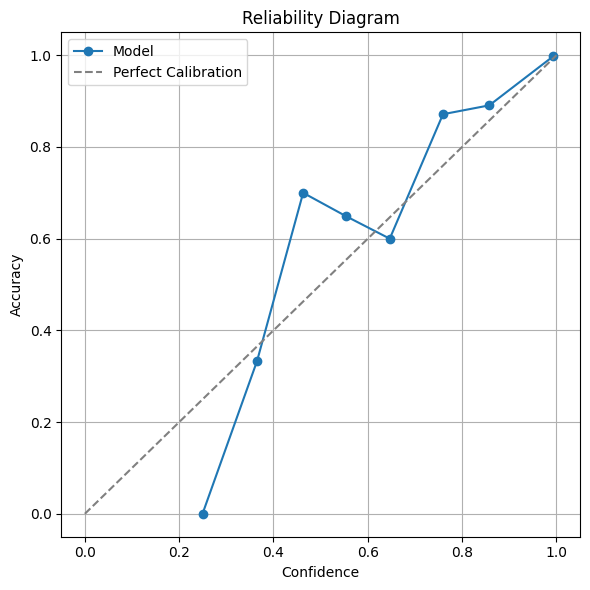

In [23]:
mean_probs, std_probs, preds = ensemble_predict_dataset(ensemble, test_loader)

# Confidence: max predicted probability
confidences = mean_probs.max(dim=1).values          # shape: (N,)
# Uncertainty: mean standard deviation over classes
uncertainties = std_probs.mean(dim=1) 

# Compute calibration curve (reliability diagram)
prob_true, prob_pred = calibration_curve(all_labels, confidences, n_bins=10)

# Plot reliability diagram
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

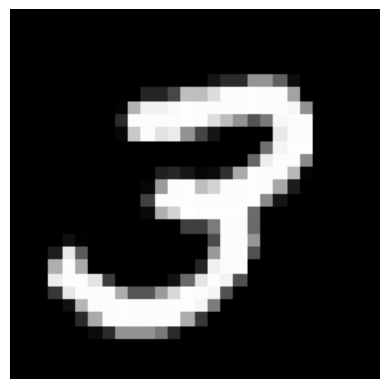

Predicted label: 3
Confidence (mean): 0.9991


In [24]:
# Prepare image tensor (same as before)
img = Image.open('data/three.png').convert('L')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
img_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
img_tensor = img_transform(img).unsqueeze(0).to(device)

# Run ensemble inference
ensemble_outputs = ensemble_predict_single_sample(ensemble, img_tensor)

# Mean and uncertainty (std across ensemble predictions)
mean_probs = ensemble_outputs.mean(dim=0)
std_probs = ensemble_outputs.std(dim=0)

predicted_label = mean_probs.argmax().item()
confidence = mean_probs.max().item()

print(f"Predicted label: {predicted_label}")
print(f"Confidence (mean): {confidence:.4f}")

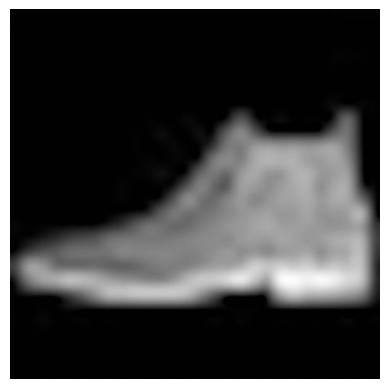

Predicted label: 2
Confidence (mean): 0.6793


In [25]:
# Prepare image tensor (same as before)
img = Image.open('data/shoe.png').convert('L')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
img_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
img_tensor = img_transform(img).unsqueeze(0).to(device)

# Run ensemble inference
ensemble_outputs = ensemble_predict_single_sample(ensemble, img_tensor)

# Mean and uncertainty (std across ensemble predictions)
mean_probs = ensemble_outputs.mean(dim=0)
std_probs = ensemble_outputs.std(dim=0)

predicted_label = mean_probs.argmax().item()
confidence = mean_probs.max().item()

print(f"Predicted label: {predicted_label}")
print(f"Confidence (mean): {confidence:.4f}")

# Test-time Augmentation

Test-Time Augmentation (TTA) applies different augmentations (e.g., flips, crops, rotations, noise) to the same test input and passing each version through the model. The predictions are then aggregated.

In [26]:

# Define test-time augmentations (TTA)
tta_transforms = [
    transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.RandomRotation(15),
        transforms.ToTensor()
    ]),
    transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor()
    ]),
    transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.RandomVerticalFlip(p=1.0),
        transforms.ToTensor()
    ]),
    transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.ToTensor()
    ]),
    transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])
]


In [27]:
def tta_predict_single_sample(model, image, tta_transforms, device):
    """
    Perform Test-Time Augmentation on a single PIL image.

    Args:
        model: Trained classifier
        image: PIL image
        tta_transforms: List of torchvision transforms
        device: torch.device

    Returns:
        mean_probs: Mean softmax probabilities over augmentations
        std_probs: Standard deviation of softmax probabilities
    """
    model.eval()
    preds = []

    with torch.no_grad():
        for transform in tta_transforms:
            augmented = transform(image).unsqueeze(0).to(device)  # shape (1, C, H, W)
            output = model(augmented)
            probs = torch.softmax(output, dim=1)
            preds.append(probs.cpu().squeeze(0))  # shape (num_classes,)

    stacked = torch.stack(preds)  # shape: (num_augs, num_classes)
    mean_probs = stacked.mean(dim=0)
    std_probs = stacked.std(dim=0)
    return mean_probs, std_probs

def tta_predict_dataset(model, dataset, tta_transforms, device):
    """
    Perform Test-Time Augmentation on an entire dataset of PIL images.

    Args:
        model: Trained classifier
        dataset: A dataset object that returns PIL images (e.g., torchvision.datasets.MNIST)
        tta_transforms: List of torchvision transforms (augmentations)
        device: torch.device

    Returns:
        mean_probs: Tensor of shape (N, C) with mean softmax probabilities
        std_probs: Tensor of shape (N, C) with std of softmax probabilities
        predicted_labels: Tensor of shape (N,) with predicted class indices
    """
    model.eval()
    all_mean_probs = []
    all_std_probs = []

    with torch.no_grad():
        for i in range(len(dataset)):
            image, _ = dataset[i]  # Only use the image, not the label
            preds = []
            pil_img = to_pil_image(image)  # Convert tensor to PIL image
            for transform in tta_transforms:
                augmented = transform(pil_img).unsqueeze(0).to(device)
                output = model(augmented)
                probs = torch.softmax(output, dim=1)
                preds.append(probs.cpu().squeeze(0))

            stacked = torch.stack(preds)
            mean_probs = stacked.mean(dim=0)
            std_probs = stacked.std(dim=0)

            all_mean_probs.append(mean_probs)
            all_std_probs.append(std_probs)

    mean_probs = torch.stack(all_mean_probs)           # shape (N, C)
    std_probs = torch.stack(all_std_probs)             # shape (N, C)
    predicted_labels = mean_probs.argmax(dim=1)        # shape (N,)

    return mean_probs, std_probs, predicted_labels




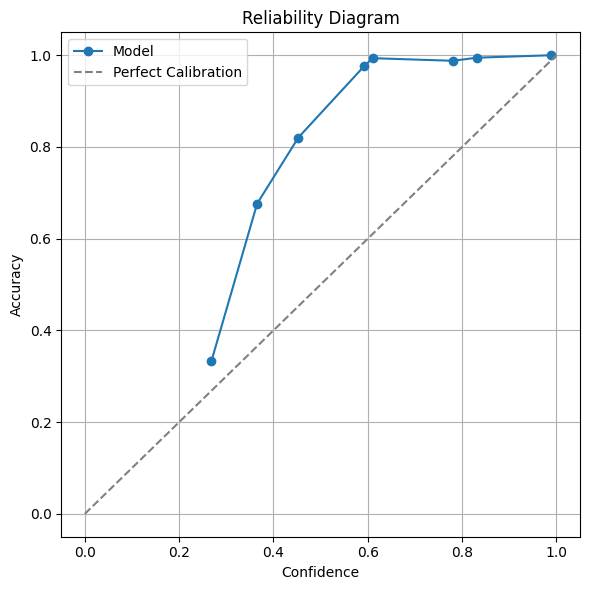

In [28]:
# Call TTA
mean_probs, std_probs, preds = tta_predict_dataset(classifier, test_dataset, tta_transforms, device)

# Analyze
confidences = mean_probs.max(dim=1).values
uncertainties = std_probs.mean(dim=1)

# Compute calibration curve (reliability diagram)
prob_true, prob_pred = calibration_curve(all_labels, confidences, n_bins=10)

# Plot reliability diagram
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Reliability Diagram')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

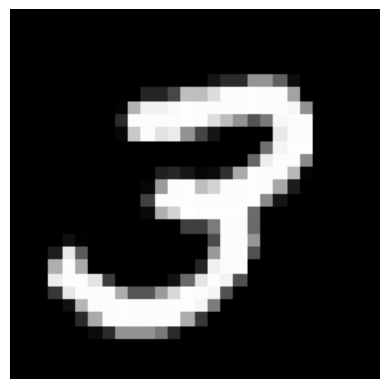

Predicted label: 3
Confidence (mean): 0.7999


In [29]:
# Load image
img = Image.open('data/three.png').convert('L')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# Run TTA inference
mean_probs, std_probs = tta_predict_single_sample(classifier, img, tta_transforms, device)

predicted_label = mean_probs.argmax().item()
confidence = mean_probs.max().item()

print(f"Predicted label: {predicted_label}")
print(f"Confidence (mean): {confidence:.4f}")

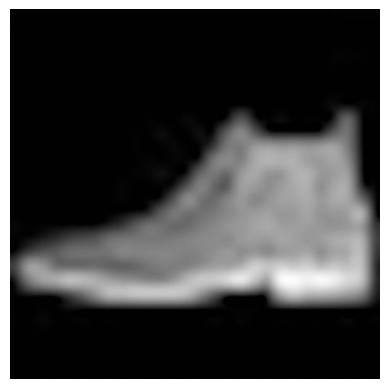

Predicted label: 1
Confidence (mean): 0.4696


In [30]:
# Load image
img = Image.open('data/shoe.png').convert('L')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# Run TTA inference
mean_probs, std_probs = tta_predict_single_sample(classifier, img, tta_transforms, device)

predicted_label = mean_probs.argmax().item()
confidence = mean_probs.max().item()

print(f"Predicted label: {predicted_label}")
print(f"Confidence (mean): {confidence:.4f}")

# Going Further

Evaluate these methods on your own dataset and see which method gives a better accuracy and calibration. 